In [2]:
import dask.dataframe as dd
import pandas as pd
import datetime

In [3]:
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df_ct = dd.read_csv("s3://senior-essay-economics/DTM_reindex/count_2gram_*.csv")

In [4]:
df_doc = dd.read_csv("s3://senior-essay-economics/DTM_reindex/doc_id_*.csv")

In [6]:
df_doc.date = df_doc.date.map(lambda x: pd.to_datetime(x, errors='coerce'))

In [7]:
df_ct.head()

,doc_id,term_id,count
0,0,121474,2
1,0,132349,3
2,0,135813,3
3,0,145882,2
4,1,71960,1


In [7]:
df_doc.head()

,permno,date,doc_id
0,47730,1979-06-27,0
1,20482,1979-06-14,1
2,20482,1979-06-26,2
3,23341,1979-06-28,3
4,17670,1979-06-18,4


# Companies Covered Over Time

In [15]:
df_doc['d_year'] = df_doc.date.apply(lambda x: x.year)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/dask/dataframe/core.py:2165: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [10]:
permnos_by_year = df_doc.groupby('d_year').apply(lambda grp: grp.permno.nunique())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  if __name__ == '__main__':


In [11]:
permnos_by_year = permnos_by_year.compute()

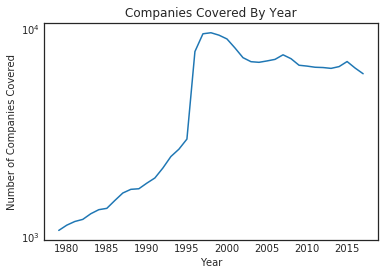

In [12]:
permnos_by_year.sort_index().plot()
plt.xlabel("Year")
plt.ylabel("Number of Companies Covered")
plt.title("Companies Covered By Year")
plt.yscale('log')

We initially have ~1000 companies, and this increases to nearly 10,000 firms as time passes.

# Number of News Articles Over Time

In [13]:
date_doc_cts = df_doc.groupby('date').apply(lambda sub_df: sub_df.doc_id.count())

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  if __name__ == '__main__':


In [14]:
date_doc_cts_pd = date_doc_cts.compute()

In [15]:
date_doc_cts_pd.sort_index(inplace=True)

In [16]:
date_doc_cts_pd.index = date_doc_cts_pd.index.to_datetime()

Text(0.5,1,'Number of Documents By Month')

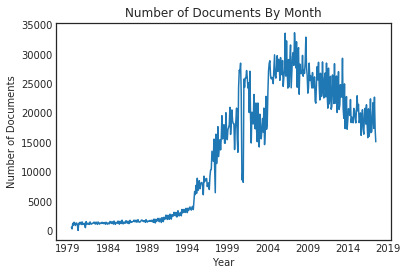

In [17]:
date_doc_cts_pd.resample('M').sum().plot()
plt.xlabel('Year')
plt.ylabel("Number of Documents")
plt.title("Number of Documents By Month")

Documents by month increases sharply in the mid-1990s. (Internet boom?) This statistic has decreased over the past decade.

# News Article Frequency Over Time

In [18]:
cts_pno_yr = df_doc.groupby(['permno', 'd_year']).apply(lambda grp: grp.doc_id.count()).compute()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  if __name__ == '__main__':


In [19]:
med_cts = cts_pno_yr.groupby('d_year').median()

Text(0.5,1,'Median Number of Firm News Articles by Year')

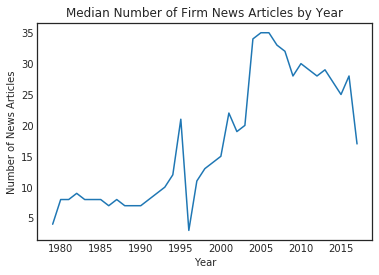

In [20]:
med_cts.plot()
plt.xlabel("Year")
plt.ylabel("Number of News Articles")
plt.title("Median Number of Firm News Articles by Year")

The median firm has generally had 5-35 news articles per year. This suggests that we will need to manage staleness of news data, at least for some firms and some time periods.

# Distribution of Firms' News Article Frequencies

In [21]:
cts_pno_yr.sort_index(level=1, inplace=True)

In [52]:
#years = cts_pno_yr.index.levels[1]

In [23]:
import warnings

In [24]:
warnings.filterwarnings('ignore', message="The 'normed' kwarg*")

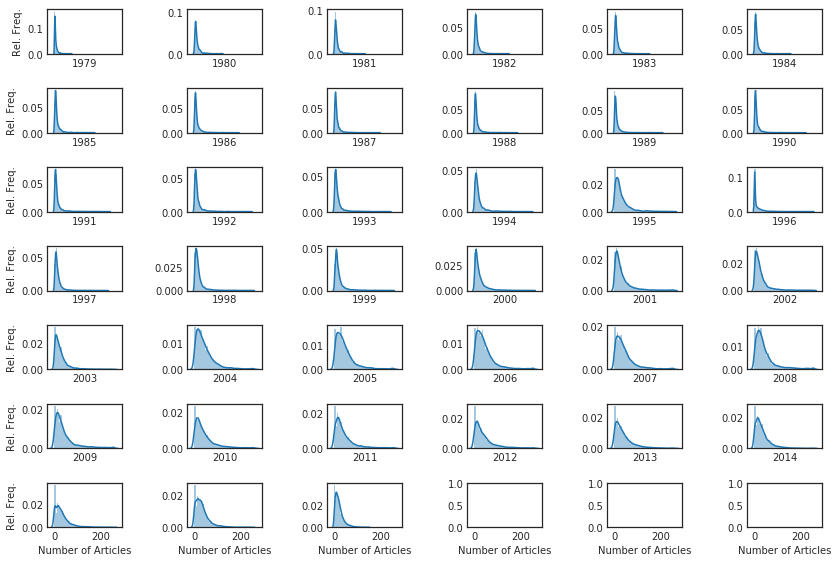

In [36]:
nx = 6
ny = 7
fig, axs = plt.subplots(ny, nx, sharex=True, sharey=False)
axs = axs.ravel()
for i, year in enumerate(years.values):
    sns.distplot(cts_pno_yr.loc[:,year], ax=axs[i])
    axs[i].set_xlabel(year)
    if (i % nx) == 0:
        axs[i].set_ylabel("Rel. Freq.")
        
for i,ax in enumerate(axs):
    if (i > (nx -1)*ny):
        axs[i].set_xlabel("Number of Articles")
        

fig.tight_layout(pad=1.0, h_pad=1.0, w_pad=1.0, rect=(0,0, 2, 2))

As time has passed, the modal article frequency has been fairly stable, but generally there have been a greater proportion of high-frequency firms in years with a large number of articles.

# Article Word Count Over Time

In [16]:
doc_wrds = df_ct.groupby('doc_id')['count'].sum().compute()

In [17]:
pd_doc = df_doc.compute()

In [18]:
joined = pd_doc.join(doc_wrds, on='doc_id')

In [19]:
joined.dropna(inplace=True)

In [20]:
mean_wrd_ct_by_year = joined.groupby('d_year')['count'].mean()

Text(0.5,1,'Article Length over time')

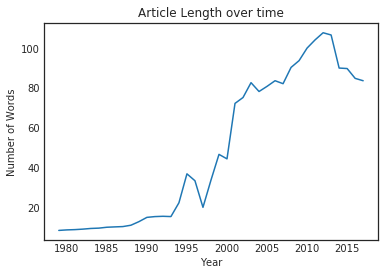

In [21]:
mean_wrd_ct_by_year.plot()
plt.xlabel("Year")
plt.ylabel("Number of Words")
plt.title("Article Length over time")

Articles have gotten longer over time. However, they are quite short for most of the sample.

# Distribution of Firms' Article Word Counts

In [33]:
import warnings

In [34]:
warnings.filterwarnings('ignore', message="The 'normed' kwarg*")

In [35]:
years = mean_wrd_ct_by_year.index

In [44]:
import numpy as np

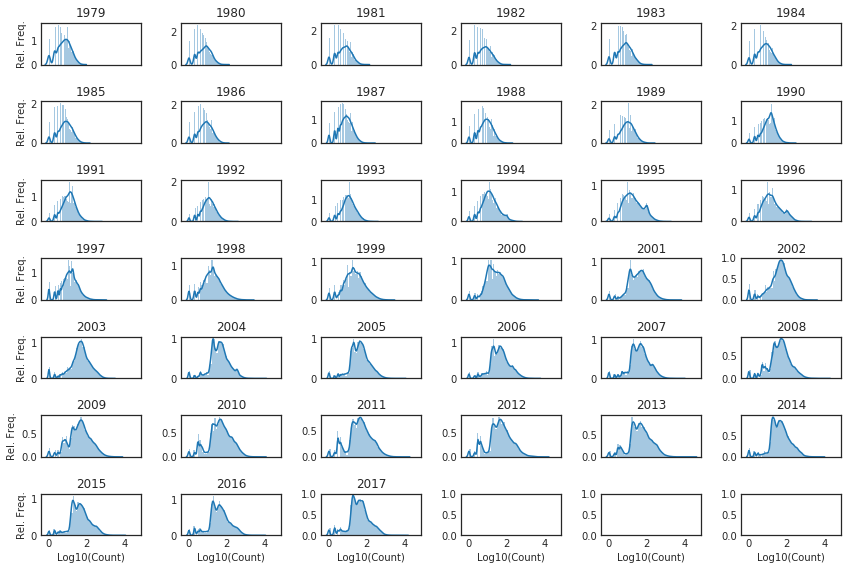

In [53]:
nx = 6
ny = 7
fig, axs = plt.subplots(ny, nx, sharex=True, sharey=False)
axs = axs.ravel()
for i, year in enumerate(years.values):
    cts = joined.loc[joined.d_year==year]['count']
    sns.distplot(np.log10(cts), ax=axs[i])

    axs[i].set_xlabel("")
    if (i % nx)==0:
        axs[i].set_ylabel("Rel. Freq.")
    else:
        axs[i].set_ylabel("")
    axs[i].set_title(year)
        
for i, ax in enumerate(axs):
    if i > (nx - 1)*ny:
        ax.set_xlabel("Log10(Count)")
fig.tight_layout(pad=1.0, h_pad=1.0, w_pad=1.0, rect=(0,0, 2, 2))

The relative frequency of firms with very low word counts has declined over time.